In [1]:
#@markdown ##import core
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import scipy.io
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
 
## settings
#plt.style.use('dark_background')
plt.style.use('default') 

In [7]:
#@markdown ##import colab
from google.colab import drive
wd = '/gdrive/MyDrive/1 UNI/BIO/'

## google drive
drive.mount('/gdrive', force_remount=True)
data = pd.read_csv( wd +'cell1_tr1000_def500.csv',
                   header = None, names=["x", "y", "z", "n", "bg","fit","id","frame"])
drift = pd.read_csv( wd + 'day2_cell1_driftValues.csv')

Mounted at /gdrive


In [2]:
#@markdown ##import jupyter
#%matplotlib ipympl
#%matplotlib widget
#%matplotlib interactive
%matplotlib inline
import trackpy
#import sdt
#from sdt import io, chromatic, multicolor, brightness
    
## local
wd = 'data/210422_npc_red_defocus/'
data = pd.read_csv( wd + 'cell1_tr1000_def500.csv',
                   header = None,
                   names=["x", "y", "z", "n", "bg","fit","id","frame"] )
drift = pd.read_csv( wd + 'day2_cell1_driftValues.csv')

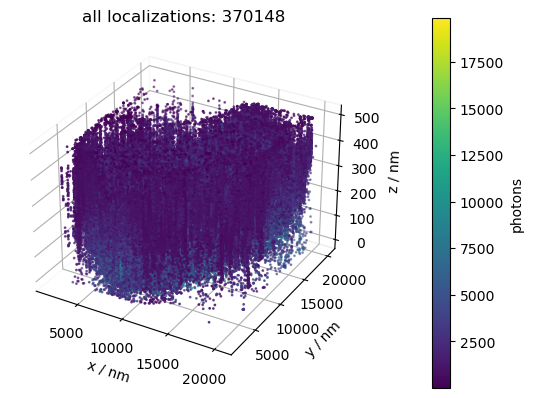

In [3]:
#@markdown ## plot raw data
#@markdown > import **colab** or **jupyter** first.
#data = data.iloc[0:1000,0:4]

fig = plt.figure()
ax = fig.add_subplot( projection = '3d' )
f = ax.scatter( data['x'], data['y'], data['z'], s=1 ,c=data['n'] )
ax.set_xlabel('x / nm')
ax.set_ylabel('y / nm')
ax.set_zlabel('z / nm')
plt.title( 'all localizations: ' + str( len( data ) ) )
cbar = plt.colorbar( f, label = 'photons', pad=0.15)
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
plt.savefig( wd + "1_raw.png", dpi=300, facecolor='w', edgecolor='w', bbox_inches='tight', pad_inches=0.1, orientation='portrait' )

In [30]:
#@markdown ## import & scale drift
#@markdown > set **magnification** via factor in drift.
 
drift['Y2']=drift['Y2']*146.6
drift['Y3']=drift['Y3']*146.6
drift['X2']=np.round(drift['X2'])
drift['X3']=np.round(drift['X3'])
 
drift

,X0,Y0,Y1,X2,Y2,X3,Y3
0,2549.5,0.000000,0.000000,1.0,1.280111,1.0,0.702067
1,8463.5,-0.013807,-0.013910,251.0,1.154475,251.0,0.633165
2,16224.0,0.003017,-0.056257,501.0,1.028985,501.0,0.564263
3,26638.5,0.022213,-0.151049,751.0,0.903349,751.0,0.495361
4,41329.0,0.095120,-0.212733,1001.0,0.777860,1001.0,0.426606
...,...,...,...,...,...,...,...
195,NaN,NaN,NaN,48750.0,20.570032,48750.0,-33.802295
196,NaN,NaN,NaN,49000.0,20.793304,49000.0,-33.890402
197,NaN,NaN,NaN,49250.0,21.016429,49250.0,-33.978508
198,NaN,NaN,NaN,49500.0,21.239701,49500.0,-34.066615


In [31]:
#@markdown ## apply drift correction
 
for i in range(len(drift)-1):
    fr=data[(data['frame']>=drift['X2'].iloc[i]) &
            (data['frame']<drift['X2'].iloc[i+1])]
    fr['y']=fr['y']-drift['Y2'].iloc[i]
    fr['x']=fr['x']-drift['Y3'].iloc[i]
    data[(data['frame']>=drift['X2'].iloc[i]) &
         (data['frame']<drift['X2'].iloc[i+1])]=fr

<ipython-input-31-75f7f9d10705>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fr['y']=fr['y']-drift['Y2'].iloc[i]
<ipython-input-31-75f7f9d10705>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fr['x']=fr['x']-drift['Y3'].iloc[i]
<ipython-input-31-75f7f9d10705>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

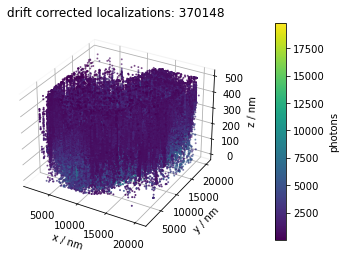

In [34]:
#@markdown ## plot drift corrected data
 
fig=plt.figure()
ax = fig.add_subplot( projection = '3d' )
f=ax.scatter( data['x'], data['y'], data['z'], s=1 ,c=data['n'] )
ax.set_xlabel('x / nm')
ax.set_ylabel('y / nm')
ax.set_zlabel('z / nm')
plt.title( 'drift corrected localizations: ' + str( len( data ) ) )
cbar=plt.colorbar( f, label = 'photons', pad=0.15 )
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
plt.savefig( wd + "2_drift.png", dpi=300, facecolor='w', edgecolor='w', bbox_inches='tight', pad_inches=0.1, orientation='portrait' )

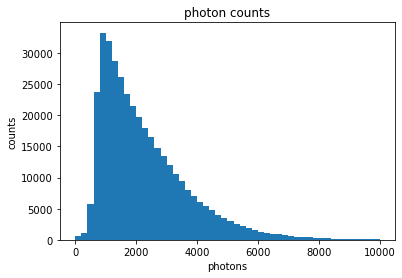

In [35]:
#@markdown ## Check: photon counts
#@markdown > set `max_photons` accordingly (default: 10000).
max_photons = 10000 #@param {type:"slider", min:0, max:40000, step:1000}
 
fig = plt.figure()
plt.hist( data['n'], bins=50, range=( 0, max_photons ) )
plt.title('photon counts')
plt.xlabel('photons')
plt.ylabel('counts')
plt.tight_layout
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
plt.savefig( wd + "3_photons.png", dpi=300, facecolor='w', edgecolor='w', bbox_inches='tight', pad_inches=0.1, orientation='portrait' )

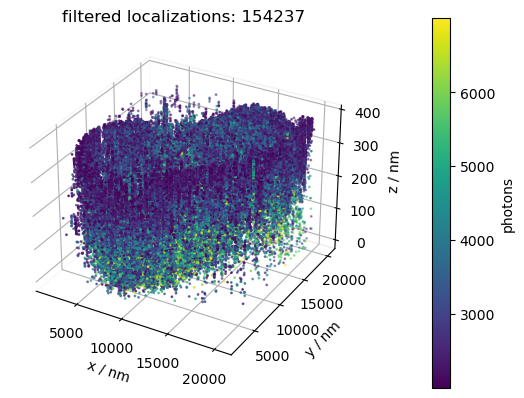

In [4]:
#@markdown ## filter
#@markdown > set `min_photons` and `max_photons` accordingly (default: 2000 < photons < 7000).\
#@markdown > set `min_z` and `max_z` accordingly (default: 0 < z < 499).\
#@markdown > set `min_fit` accordingly (default: 6e6).
min_photons = 2000 #@param {type:"slider", min:0, max:40000, step:1000}
max_photons = 7000 #@param {type:"slider", min:0, max:40000, step:1000}
min_z = 0 #@param {type:"slider", min:0, max:500, step:1}
max_z = 384 #@param {type:"slider", min:0, max:500, step:1}
min_fit = 7192000 #@param {type:"slider", min:0, max:1e7, step:1000}
 
fdata = data[ ( data['n'] > min_photons ) &
             ( data['n'] < max_photons ) & 
             ( data['z'] > min_z ) &
             ( data['z'] < max_z ) &
             ( data['fit'] < min_fit ) ]
 
fig = plt.figure()
ax = fig.add_subplot( projection = '3d' )
ff = ax.scatter( fdata['x'], fdata['y'], fdata['z'], s=1 ,c=fdata['n'] )
ax.set_xlabel('x / nm')
ax.set_ylabel('y / nm')
ax.set_zlabel('z / nm')
plt.title( 'filtered localizations: ' + str( len( fdata ) ) )
cbar = plt.colorbar( ff, label = 'photons', pad=0.15 )
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
plt.savefig( wd + "4_filter.png", dpi=300, facecolor='w', edgecolor='w', bbox_inches='tight', pad_inches=0.1, orientation='portrait' ) # colorbar: pad=0.15 

In [5]:
#@markdown ## track all in x,y
#@markdown > set `sr` to wanted search range (default: 50).\
#@markdown > set `mem` to wanted memory (default: 10).
sr = 50 #@param {type:"slider", min:0, max:100, step:1}
mem = 10 #@param {type:"slider", min:0, max:100, step:1}
 
linkedxy = trackpy.link_df( fdata,
                           pos_columns = ["x","y","z"],
                           search_range = sr,
                           memory = mem )
 
particles = linkedxy.groupby( "particle" ).aggregate( np.mean )
std_pos = linkedxy.groupby( "particle" ).aggregate( 'std' )
particles["length"] = linkedxy.groupby( "particle" ).apply( len )
particles["z_std"] = std_pos['z'].copy()
particles["x_std"] = std_pos['x'].copy()
particles["y_std"] = std_pos['y'].copy()
 
particles

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



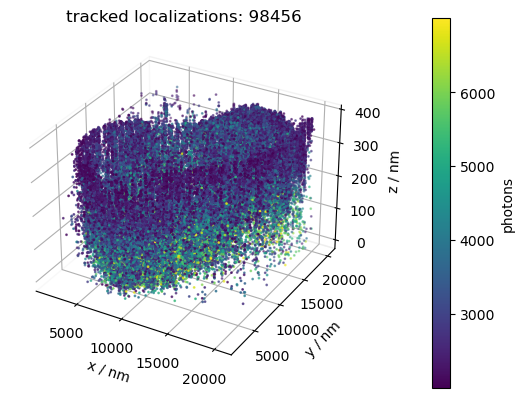

In [15]:
#@markdown ## cut down to tracked particles
#@markdown > set `localisations = particles` if tracking.\
#@markdown > set `localisations = fdata.iloc[0:10000,0:4]` otherwise to select first 10000 rows.
tracking = True #@param {type:"boolean"}
if tracking:
  localisations = particles
else:
  localisations = fdata.iloc[0:100000000,0:4]
 
fig = plt.figure()
ax = fig.add_subplot( projection = '3d' )
ff = ax.scatter( localisations['x'], localisations['y'], localisations['z'], s=1 ,c=localisations['n'] )
ax.set_xlabel('x / nm')
ax.set_ylabel('y / nm')
ax.set_zlabel('z / nm')
plt.title( 'tracked localizations: ' + str( len( localisations ) ) )
cbar = plt.colorbar( ff, label = 'photons', pad=0.15 )
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
plt.savefig( wd + "5_tracking.png", dpi=300, facecolor='w', edgecolor='w', bbox_inches='tight', pad_inches=0.1, orientation='portrait' ) # colorbar: pad=0.15 

/home/m/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass min_samples=50 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


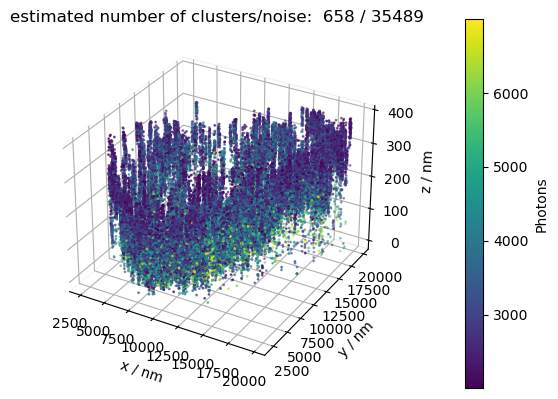

In [14]:
#@markdown ## compute dbscan
#@markdown > set `dim = 2` for clustering in x and y (default:).\
#@markdown > set `dim = 3` for experimental clustering in 3d; be aware that x,z and y precision probably vary!\
#@markdown > set `eps` (default: 200).\
#@markdown > set `min_samples` (default: 10).
dim = "2" #@param [2, 3]
eps = 100 #@param {type:"slider", min:0, max:500, step:10}
min_samples = 50 #@param {type:"slider", min:1, max:100, step:1}

alocalisations = localisations.to_numpy()
alocalisations[ :, 0:2 ]

db = DBSCAN( eps, min_samples ).fit( alocalisations[ :, 0:int( dim ) ] )
core_samples_mask = np.zeros_like( db.labels_, dtype=bool )
core_samples_mask[ db.core_sample_indices_ ] = True
labels = db.labels_
localisations[ "cluster" ] = labels

# count clusters (ignore noise if present)
n_clusters_ = len( set( labels ) ) - ( 1 if -1 in labels else 0 )
n_noise_ = list( labels ).count( -1 )

#print('Estimated number of clusters: %d' % n_clusters_)
#print('Estimated number of noise points: %d' % n_noise_)

nlocalisations = localisations.loc[ localisations['cluster'] == -1 ]
clocalisations = localisations.loc[ localisations['cluster'] != -1 ]

fig = plt.figure()
ax = fig.add_subplot( projection = '3d' )
ff = ax.scatter( clocalisations['x'], clocalisations['y'], clocalisations['z'], s=1 ,c=clocalisations['n'] )
#ff = ax.scatter( nlocalisations['x'], nlocalisations['y'], nlocalisations['z'], s=1 ,c="black" )
ax.set_xlabel('x / nm')
ax.set_ylabel('y / nm')
ax.set_zlabel('z / nm')
plt.title('{0} {1} {2} {3}'.format( 'estimated number of clusters/noise: ', n_clusters_, '/', n_noise_ ) )
cbar = plt.colorbar( ff, label = 'Photons', pad=0.15 )
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
plt.savefig( wd + "6_clustering.png", dpi=300, facecolor='w', edgecolor='w', bbox_inches='tight', pad_inches=0.1, orientation='portrait' ) # colorbar: pad=0.15 

In [8]:
#@markdown ## analyse clusters
#@markdown > set `npc_radius` to NPC radius /nm (default: 50).\
#@markdown > set `npc_radius` to NPC haight /nm (default: 150).
npc_radius = 50 #@param {type:"slider", min:0, max:500, step:1}
npc_height = 25 #@param {type:"slider", min:0, max:500, step:1}

clabels = set(labels)
cnames = [ "counts", "xmean", "ymean", "zmean", "nmean", "xvar", "yvar", "zvar",
          "nvar", "label", "ringness", "twofold" ]
clusters = pd.DataFrame( index = clabels, columns = cnames, dtype="float64" )
clusters[ "label" ] = clabels

for k in clabels:
  tmp = localisations.loc[ localisations['cluster'] == k ]
  clusters.loc[ k, "counts" ] = len( tmp )
  for label in [ "x", "y", "z", "n" ]:
    clusters.loc[ k, label+"mean"  ] = np.mean( tmp.loc[ :, label ] )
    clusters.loc[ k, label+"var"  ] = np.var( tmp.loc[ :, label ] )

  ## xy: radius (distance to centroid)
  rad = np.sqrt( ( tmp.loc[ :, "x" ] - clusters.loc[ k, "xmean" ] )**2 + 
                ( tmp.loc[ :, "y" ] - clusters.loc[ k, "ymean" ] )**2 )
  ## xy: radius rms deviation from NPC radius
  clusters.loc[ k, "ringness"  ] = np.sqrt( sum( ( rad - npc_radius )**2 ) )

  ## z: radius (distance to centroid)
  rad = abs( tmp.loc[ :, "z" ] - clusters.loc[ k, "zmean" ] )
  ## z: radius rms deviation from NPC radius
  clusters.loc[ k, "twofold"  ] = np.sqrt( sum( ( rad - npc_height )**2 ) )

print( * [ 'analysed clusters: ', len( clusters ) ] )

analysed clusters:  659


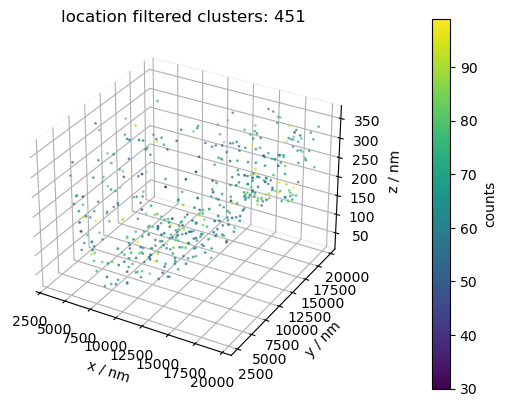

In [9]:
#@markdown ## filter clusters
#@markdown > set `count_threshold` to min elements (counts) in cluster (default: 30)\
#@markdown > set `diameter_threshold` to max x,y (radius) deviation of cluster from NPC diameter (default: 200)\
#@markdown > set `twofold_threshold` to max z (radius) deviation of cluster from NPC height (default: 200)\
#@markdown > set `xyvar_threshold` to wanted x,y variance (default: 1e4)\
#@markdown > set `zvar_threshold` to wanted z variance (default: 1e4)
count_threshold = 100 #@param {type:"slider", min:0, max:200, step:1}
diameter_threshold = 500 #@param {type:"slider", min:0, max:500, step:10}
twofold_threshold = 1000 #@param {type:"slider", min:0, max:1000, step:10}
xyvar_threshold = 100000 #@param {type:"slider", min:0, max:1e5, step:1e3}
zvar_threshold = 100000 #@param {type:"slider", min:0, max:1e5, step:1e3}

fclusters = clusters[ ( clusters['counts'] < count_threshold ) &
                     ( clusters['ringness'] < diameter_threshold ) &
                     ( clusters['twofold'] < twofold_threshold ) &
                     ( clusters['xvar'] < xyvar_threshold ) & 
                     ( clusters['yvar'] < xyvar_threshold ) &
                     ( clusters['zvar'] < zvar_threshold ) ]

fig = plt.figure()
ax = fig.add_subplot( projection = '3d' )
ff = ax.scatter( fclusters['xmean'], fclusters['ymean'], fclusters['zmean'], s=1 ,c=fclusters['counts'] )
ax.set_xlabel('x / nm')
ax.set_ylabel('y / nm')
ax.set_zlabel('z / nm')
plt.title( 'location filtered clusters: ' + str( len( fclusters ) ) )
cbar = plt.colorbar( ff, label='counts', pad=0.15 )
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
plt.savefig( wd + "7_filtered_clusters.png", dpi=300, facecolor='w', edgecolor='w', bbox_inches='tight', pad_inches=0.1, orientation='portrait' ) # colorbar: pad=0.15 

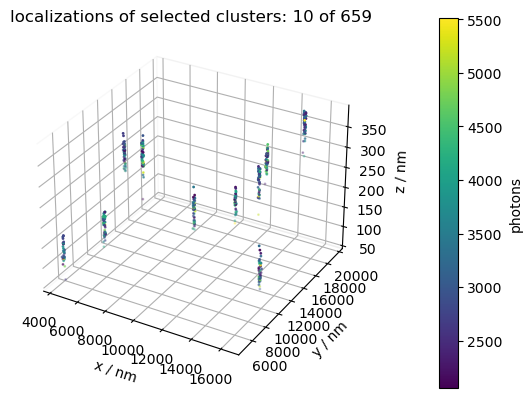

In [10]:
#@markdown ## select best clusters & plot localisations
#@markdown > set `show_clusters` to wanted number of best clusters (default: 100).\
#@markdown > set `sort` to sort the best clusters (default: ringness + twofold).
show_clusters = 10 #@param {type:"slider", min:0, max:1000, step:1}
sort = 'ringness + twofold' #@param [ "ringness + twofold", "twofold", "ringness", "xyvar" , "xvar" ]

if sort == "xvar": # sort by variance
    sclusters = fclusters.sort_values( "xvar" )
elif sort == "xyvar": # sort by x and y variance using least squares
    sclusters = fclusters.loc[
        ( fclusters.xvar ** 2 + fclusters.yvar ** 2 ).sort_values().index ]
elif sort == "ringness": # sort by ringness (deviation to ringness)
    sclusters = fclusters.sort_values( "ringness" )
elif sort == "twofold": # sort by ringness (deviation to ringness)
    sclusters = fclusters.sort_values( "twofold" )
elif sort == "ringness + twofold": # sort by ringness (deviation to ringness)
    sclusters = fclusters.loc[
        ( fclusters.twofold ** 2 + fclusters.ringness ** 2 ).sort_values().index ]

show_clusters = min( show_clusters, len( sclusters ) )
selected_clusters = sclusters["label"].iloc[ 0:show_clusters ]

fig = plt.figure()
ax = fig.add_subplot( projection = '3d' )
for clus in selected_clusters:
  flocalisations = localisations[ ( localisations['cluster'] == clus ) ]
  ff = ax.scatter( flocalisations['x'],
                  flocalisations['y'],
                  flocalisations['z'],
                  s=1 ,c = flocalisations['n'] )

ax.set_xlabel('x / nm')
ax.set_ylabel('y / nm')
ax.set_zlabel('z / nm')
plt.title( "localizations of selected clusters: " + 
          str( len( selected_clusters ) ) +
          ' of ' + str( len( clusters ) ))
cbar = plt.colorbar( ff, label = 'photons', pad=0.15 )
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
plt.savefig( wd + "8_best_filtered_clusters.png", dpi=300, facecolor='w', edgecolor='w', bbox_inches='tight', pad_inches=0.1, orientation='portrait' ) # colorbar: pad=0.15 

/usr/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


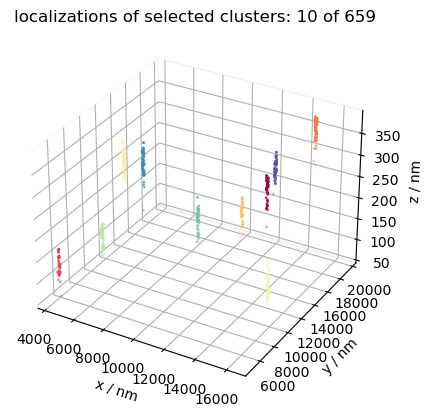

In [16]:
#@markdown ## plot localisations as colored clusters

sclusters['color'] = ""
vec = np.linspace( 0, 1, len( selected_clusters ) )
for each in range( len( selected_clusters ) ):
  sclusters['color'].iloc[ each ] = plt.cm.Spectral( vec[ each ] )

fig = plt.figure()
ax = fig.add_subplot( projection = '3d' )
for clus in selected_clusters:
  flocalisations = localisations[ ( localisations['cluster'] == clus ) ]
  #print( tuple(  sclusters.loc[clus, "color" ] ) )
  ff = ax.scatter( flocalisations['x'], flocalisations['y'], flocalisations['z'],
                  s=1 ,color = tuple(  sclusters.loc[ clus, "color" ] ) )

ax.set_xlabel('x / nm')
ax.set_ylabel('y / nm')
ax.set_zlabel('z / nm')
plt.title( "localizations of selected clusters: " + 
          str( len( selected_clusters ) ) +
          ' of ' + str( len( clusters ) ))
#cbar = plt.colorbar( ff, label = 'cluster', pad=0.15 )
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
plt.savefig( wd + "9_best_filtered_clusters.png", dpi=300, facecolor='w', edgecolor='w', bbox_inches='tight', pad_inches=0.1, orientation='portrait' ) # colorbar: pad=0.15 

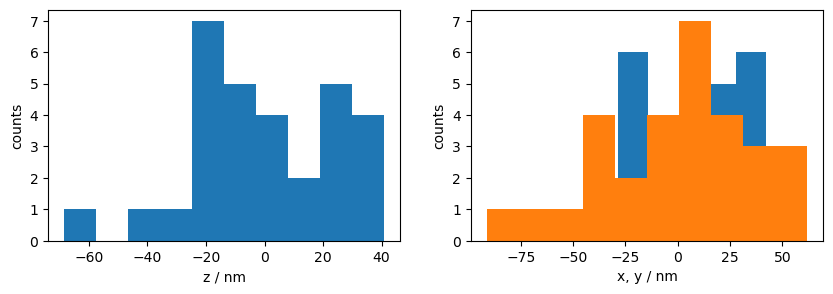

In [50]:
#@markdown ## Check: z distribution
#@markdown > set `plot_cluster` to wanted cluster (default: 0).
plot_cluster = 1 #@param {type:"slider", min:0, max:100, step:1}
plot_cluster = min( plot_cluster, len( sclusters ) -1 )

tmp = localisations.loc[ localisations['cluster'] == 
                        sclusters.loc[ sclusters.index[ plot_cluster ],
                                      "label" ] ]

z = tmp.z - np.mean( tmp.z )

fig, axes = plt.subplots( 1, 2, figsize=(10, 3) ) # figsize=(4, 12)

axes[0].hist( tmp.z - np.mean( tmp.z ) )
axes[0].set_xlabel('z / nm')
axes[0].set_ylabel('counts')
#axes[0].set_title( 'z' )

axes[1].hist( tmp.x - np.mean( tmp.x ) )
axes[1].hist( tmp.y - np.mean( tmp.y ) )
axes[1].set_ylabel('counts')
axes[1].set_xlabel('x, y / nm')
#axes[1].set_title( 'x, y' )

#fig.suptitle( 'normalised z distribution of cluster ' + str( plot_cluster ) )
plt.savefig( wd + "10_histograms_" + str(plot_cluster) + ".png", dpi=300, facecolor='w', edgecolor='w', bbox_inches='tight', pad_inches=0.1, orientation='portrait' ) # colorbar: pad=0.15 

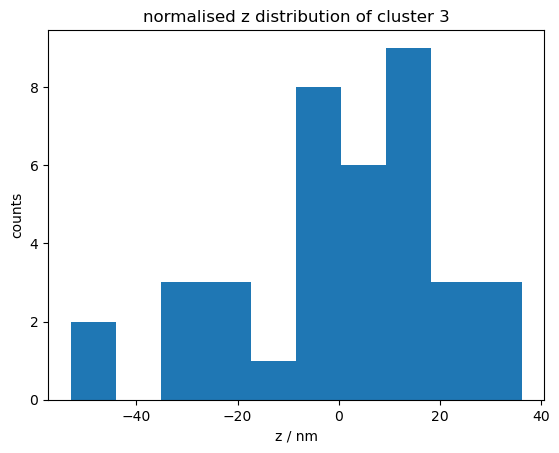

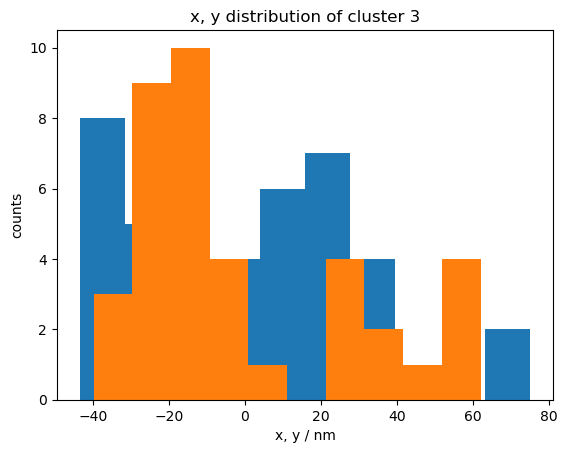

In [18]:
#@markdown ## split plots

fig = plt.figure()
plt.hist( tmp.z - np.mean( tmp.z ) )
plt.xlabel('z / nm')
plt.ylabel('counts')
plt.title( 'normalised z distribution of cluster ' + str( plot_cluster ) )
plt.savefig( wd + "11_z_best_filtered_clusters.png", dpi=300, facecolor='w', edgecolor='w', bbox_inches='tight', pad_inches=0.1, orientation='portrait' ) # colorbar: pad=0.15 

fig = plt.figure()
plt.hist( tmp.x - np.mean( tmp.x ) )
plt.hist( tmp.y - np.mean( tmp.y ) )
plt.ylabel('counts')
plt.xlabel('x, y / nm')
plt.title( 'x, y distribution of cluster ' + str( plot_cluster ) )
plt.savefig( wd + "12_xy_best_filtered_clusters.png", dpi=300, facecolor='w', edgecolor='w', bbox_inches='tight', pad_inches=0.1, orientation='portrait' ) # colorbar: pad=0.15 